

> Tambahkan blockquote



In [6]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Membuat model untuk sistem rekomendasi


# **Membuat desain model CNN untuk klasifikasi jenis - jenis tanah**

 kami mengambil dataset tanah dari [kagle](https://www.kaggle.com/datasets/fuadkahfi/dataset-tanah), kita mendapat 8 sampel jenis tanah dan total 880 datasets

untuk model arsitektur, kami meniru style [VGGNet CNN architecture](https://en.wikipedia.org/wiki/VGGNet). berikut model arsitektur yang kami buat:
> 320x320x3 --> 320x320x32 Conv1+ReLU --> max pooling --> 160x160x64 Conv2+ReLU --> max pooling --> 80x80x128 Conv3+ReLU --> max pooling --> Dropout(0.4) -> Flatten --> 1x1x128 fullyconnected1+ReLU --> Dropout(0.4) --> 1x1x8 fullyconnected2+softmax

dengan model tersebut, kami berhasil mendapatkan hasil yang luar biasa. hanya 4% gap antara training acc dan validation acc    
Epoch 100/100                                        
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9476 - loss: 0.1651 - val_accuracy: 0.9091 - val_loss: 0.3009

---


berikut model yang kami buat :

In [7]:
#@title Install required libraries

!pip install keras~=3.8.0 \
  matplotlib~=3.10.0 \
  numpy~=2.0.0 \
  pandas~=2.2.0

print('\n\nAll requirements successfully installed.')



All requirements successfully installed.


In [8]:
#@title Load dependencies

import io

# data
import numpy as numpy
import pandas as panda

# machine learning
import keras
import tensorflow as tf

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn

# dataset
import kagglehub
from google.colab import drive

In [9]:
#@title Mempersiapkan dataset
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/dataset_tanah.zip -d /content/dataset

path = "/content/dataset/"

batch = 32 #@param
p = 320 #@param
l = 320 #@param

# data set yang akan di latih dan validasi
split = 0.25 # @param {"type":"number"}

training_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="training",
    seed=1,

    image_size=(p, l),
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="validation",
    seed=1,

    image_size=(p, l),
    shuffle=True
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/dataset_tanah.zip
replace /content/dataset/Aluvial/aluvial-004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset/Aluvial/aluvial-004.jpg  
  inflating: /content/dataset/Aluvial/aluvial-005.jpg  
  inflating: /content/dataset/Aluvial/aluvial-006.jpg  
  inflating: /content/dataset/Aluvial/aluvial-007.jpg  
  inflating: /content/dataset/Aluvial/aluvial-008.jpg  
  inflating: /content/dataset/Aluvial/aluvial-009.jpg  
  inflating: /content/dataset/Aluvial/aluvial-010.jpg  
  inflating: /content/dataset/Aluvial/aluvial-011.jpg  
  inflating: /content/dataset/Aluvial/aluvial-012.jpg  
  inflating: /content/dataset/Aluvial/aluvial-013.png  
  inflating: /content/dataset/Aluvial/aluvial-014.jpg  
  inflating: /content/dataset/Aluvial/aluvial-015.png  
  inflating: /content/dataset/Aluvial/aluvial-016.jpg  
  

In [10]:
#@title Membuat model

jenis = len(training_dataset.class_names)
print(jenis)
droput = 0.4 #@param

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=1),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(p, l, 3)),
    tf.keras.layers.Rescaling(1./255),
    augmentation,

#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Dense(jenis, activation='softmax')
])



6


In [11]:
#@title Tahap Melatih model dan validaasi model

rate = 0.0005 # @param {"type":"number"}
epoch = 100 # @param {"type":"integer"}

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=rate),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epoch
)

# export model menjadi .tflite
model.save('model.keras')
convert = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model('model.keras'))
tflite_model = convert.convert()
with open("Tanah.tflite", "wb") as f:
    f.write(tflite_model)



Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - accuracy: 0.3504 - loss: 1.9749 - val_accuracy: 0.6051 - val_loss: 1.0213
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.6224 - loss: 0.8501 - val_accuracy: 0.6821 - val_loss: 0.9670
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.6244 - loss: 0.9221 - val_accuracy: 0.7538 - val_loss: 0.7177
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.7130 - loss: 0.7193 - val_accuracy: 0.7846 - val_loss: 0.5607
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.7729 - loss: 0.6583 - val_accuracy: 0.8564 - val_loss: 0.4573
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.7505 - loss: 0.6840 - val_accuracy: 0.8564 - val_loss: 0.4701
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.7670 - loss: 0.6044 - val_accuracy: 0.7590 - val_loss: 0.6230
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.7808 - loss: 0.5526 - val_a

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 184832)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,658,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,257,940 (271.83 MB)

 Trainable params: 23,752,646 (90.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,505,294 (181.22 MB)

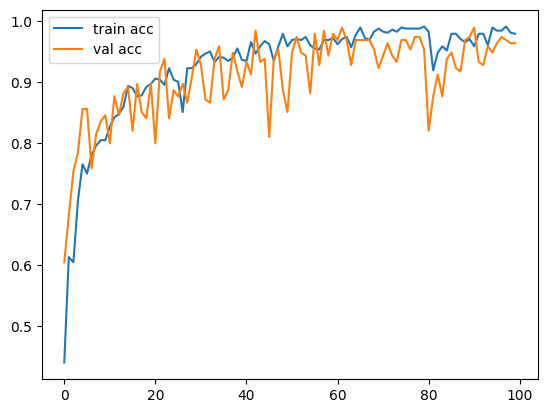

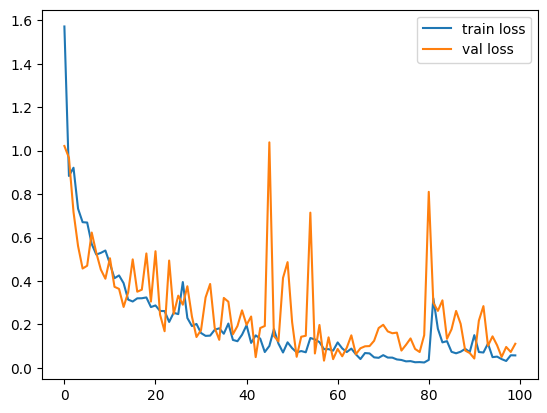

In [12]:
#@title Accuracy statistik graph

model.summary()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()




# Image classification with TensorFlow Lite Model Maker with TensorFlow 2.18.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook has been moved [here](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification).

In [13]:

print(tf.__version__)

2.18.1


https://colab.research.google.com/github/TrainingBear/OPSI-Project-AndroidApplication/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb#scrollTo=w7AdazbUlvDJ